<a href="https://colab.research.google.com/github/jax-ml/bonsai/blob/main/bonsai/models/unet/tests/UNet_segmentation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation with U-Net (Work in progress)**

This notebook is work in progress. ([#73](https://github.com/jax-ml/bonsai/issues/73))
This notebook demonstrates how to use the U-Net model from the Bonsai library to perform a simple image segmentation task.

*This colab demonstrates the U-Net implementation from the [Bonsai library](https://github.com/jax-ml/bonsai).*

## **1. Set-up**

In [ ]:
!pip install -q git+https://github.com/jax-ml/bonsai@main
!pip install -q pillow matplotlib scikit-image
!pip install tqdm -q
!pip uninstall -y jax jaxlib
!pip install -U "jax[cuda12]"

In [ ]:
import os
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import orbax.checkpoint as ocp
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import nnx
from flax.training.train_state import TrainState
from jax.lib import xla_bridge
from tqdm import tqdm

from bonsai.models.unet import modeling as unet_lib
from bonsai.models.unet import params as params_lib

print(f"JAX version: {jax.__version__}")
print(f"JAX device: {xla_bridge.get_backend().platform}")

JAX version: 0.7.2


/tmp/ipykernel_35762/209973706.py:47: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  print(f"JAX device: {xla_bridge.get_backend().platform}")


JAX device: gpu


## **2. Load Data and Train the Model**

To test the U-Net architecture, we will generate a simple synthetic image with basic shapes. The goal is to make the model predict a mask that highlights these shapes.

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 8


def load_dataset(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE):
    """Loads and preprocesses a subset of the Oxford-IIIT Pet dataset."""
    ds_builder = tfds.builder("oxford_iiit_pet")
    ds_builder.download_and_prepare()
    # Using smaller splits for faster demonstration
    train_split, test_split = ds_builder.as_dataset(split=["train[:50%]", "test[:50%]"])

    def preprocess(sample):
        image = tf.image.resize(sample["image"], (image_size, image_size))
        mask = tf.image.resize(sample["segmentation_mask"], (image_size, image_size), method="nearest")
        image = tf.cast(image, tf.float32) / 255.0
        # The mask values are 1, 2, 3. We subtract 1 to make them 0, 1, 2.
        mask = tf.squeeze(mask - 1, axis=-1)
        return image, mask

    train_ds = train_split.map(preprocess).cache().shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_split.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tfds.as_numpy(train_ds), tfds.as_numpy(test_ds)


def segmentation_loss(logits: jax.Array, labels: jax.Array) -> jax.Array:
    """Computes softmax cross-entropy loss for segmentation."""
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return jnp.mean(loss)


config = unet_lib.ModelCfg(in_channels=3, num_classes=3)
rngs = nnx.Rngs(0)

# Create the model from scratch with random initial weights
model = params_lib.create_model(cfg=config, rngs=rngs)

# Split the model into its structure (graphdef) and its state (variables)
graphdef, model_state = nnx.split(model)

# This is how you get the initial, random weights for training from scratch.
params = model_state.filter(nnx.Param)

# Extract non-trainable variables
other_vars = model_state.filter(lambda path, value: not isinstance(value, nnx.Param))

optimizer = optax.adam(learning_rate=1e-3)

train_state = TrainState.create(apply_fn=graphdef.apply, params=params, tx=optimizer)


@jax.jit
def train_step(state: TrainState, other_vars: nnx.State, batch: tuple[jax.Array, jax.Array]):
    """Performs a single training step."""
    images, masks = batch

    def loss_fn(params):
        # Recombine the graph, TRAINED params, and OTHER_VARS to build the full model
        model = nnx.merge(graphdef, params, other_vars)

        # Forward pass, converting the output proxy to a JAX array
        logits = jnp.asarray(model(images))

        # Calculate loss
        loss = segmentation_loss(logits, masks)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


print(" Starting training from scratch...")
train_loader, _ = load_dataset()
num_epochs = 100
state = train_state

for epoch in range(num_epochs):
    total_loss = 0
    batch_count = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for images, masks in pbar:
        state, loss = train_step(state, other_vars, (images, masks))
        total_loss += loss
        batch_count += 1

        if batch_count > 0:
            avg_loss = total_loss / batch_count
            pbar.set_postfix(loss=f"{avg_loss:.4f}")

print("Training finished!")

🚀 Starting training from scratch...


I0000 00:00:1758545909.490409  382907 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1106 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
Epoch 1/100:   0%|          | 0/460 [00:00<?, ?it/s]W0922 09:58:33.337973  382907 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0922 09:58:33.791425  382907 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0922 09:58:34.418209  382907 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indi

✅ Training finished!


## **3. Save the Weights**

In [ ]:
ckpt_dir = Path("./checkpoints")
ckpt_dir.mkdir(exist_ok=True)

# Use Orbax to save the PyTree of the model's parameters directly
checkpointer = ocp.PyTreeCheckpointer()

# Save state.params instead of the merged state
checkpointer.save(ckpt_dir, item=state.params, force=True)

print(f"\n Model parameters saved to: {ckpt_dir.resolve()}")


 Model parameters saved to: /home/neo/Downloads/CODE_Other_Models/bonsai/bonsai/models/unet/tests/checkpoints


## **4. Load Pre-Trained Weights and Train**

In [ ]:
###### TRAIN BY LOADING PRE TRAINED WEIGHTS ######

import sys
from pathlib import Path

import jax
import optax
import orbax.checkpoint as ocp
from flax import nnx
from flax.training.train_state import TrainState

from bonsai.models.unet import modeling as unet_lib
from bonsai.models.unet import params as params_lib

IMAGE_SIZE = 128
BATCH_SIZE = 8


def load_dataset(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE):
    """Loads and preprocesses a subset of the Oxford-IIIT Pet dataset."""
    ds_builder = tfds.builder("oxford_iiit_pet")
    ds_builder.download_and_prepare()
    train_split, test_split = ds_builder.as_dataset(split=["train", "test"])

    def preprocess(sample):
        image = tf.image.resize(sample["image"], (image_size, image_size))
        mask = tf.image.resize(sample["segmentation_mask"], (image_size, image_size), method="nearest")
        image = tf.cast(image, tf.float32) / 255.0
        mask = tf.squeeze(mask - 1, axis=-1)
        return image, mask

    train_ds = train_split.map(preprocess).cache().shuffle(10).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_split.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tfds.as_numpy(train_ds), tfds.as_numpy(test_ds)


config = unet_lib.ModelCfg(in_channels=3, num_classes=3)
rngs = nnx.Rngs(0)

# Create a template model to get BOTH the graphdef and other_vars
template_model = params_lib.create_model(cfg=config, rngs=rngs)
graphdef, model_state = nnx.split(template_model)

# Extract the non-trainable variables. These are needed for the model's structure.
other_vars = model_state.filter(lambda path, value: not isinstance(value, nnx.Param))

# Load the TRAINED parameters from your checkpoint
ckpt_dir = Path("./checkpoints")
checkpointer = ocp.PyTreeCheckpointer()
# The checkpoint correctly contains only the parameters, as saved by the example notebook
loaded_params = checkpointer.restore(ckpt_dir)

optimizer = optax.adam(learning_rate=0.2e-3)

# Initialize the TrainState with the LOADED parameters
train_state = TrainState.create(apply_fn=graphdef.apply, params=loaded_params, tx=optimizer)


@jax.jit
def train_step(state: TrainState, other_vars: nnx.State, batch: tuple[jax.Array, jax.Array]):
    """Performs a single training step."""
    images, masks = batch

    def loss_fn(params):
        # Recombine the graph, TRAINED params, and OTHER_VARS to build the full model
        model = nnx.merge(graphdef, params, other_vars)

        # Forward pass, converting the output proxy to a JAX array
        logits = jnp.asarray(model(images))

        # Calculate loss
        loss = segmentation_loss(logits, masks)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


print("🚀 Starting training from checkpoint...")
train_loader, vis_loader = load_dataset()
num_epochs = 100
state = train_state

for epoch in range(num_epochs):
    total_loss = 0
    batch_count = 0
    for images, masks in train_loader:
        # Pass other_vars to the train_step function
        state, loss = train_step(state, other_vars, (images, masks))
        total_loss += loss
        batch_count += 1
    avg_loss = total_loss / batch_count
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training finished!")

/home/neo/anaconda3/envs/bonsai/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


🚀 Starting training from checkpoint...


I0000 00:00:1758582805.425057   35762 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1106 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
W0922 20:13:32.328663   35762 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0922 20:13:32.889491   35762 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0922 20:13:33.446731   35762 bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean 

Epoch 1/100, Average Loss: 0.0951
Epoch 2/100, Average Loss: 0.0869
Epoch 3/100, Average Loss: 0.0821
Epoch 4/100, Average Loss: 0.0789
Epoch 5/100, Average Loss: 0.0760
Epoch 6/100, Average Loss: 0.0753
Epoch 7/100, Average Loss: 0.0720
Epoch 8/100, Average Loss: 0.0696
Epoch 9/100, Average Loss: 0.0678
Epoch 10/100, Average Loss: 0.0663
Epoch 11/100, Average Loss: 0.0650
Epoch 12/100, Average Loss: 0.0645
Epoch 13/100, Average Loss: 0.0630
Epoch 14/100, Average Loss: 0.0620
Epoch 15/100, Average Loss: 0.0614
Epoch 16/100, Average Loss: 0.0598
Epoch 17/100, Average Loss: 0.0585
Epoch 18/100, Average Loss: 0.0572
Epoch 19/100, Average Loss: 0.0569
Epoch 20/100, Average Loss: 0.0566
Epoch 21/100, Average Loss: 0.0554
Epoch 22/100, Average Loss: 0.0555
Epoch 23/100, Average Loss: 0.0550
Epoch 24/100, Average Loss: 0.0533
Epoch 25/100, Average Loss: 0.0525
Epoch 26/100, Average Loss: 0.0514
Epoch 27/100, Average Loss: 0.0513
Epoch 28/100, Average Loss: 0.0514
Epoch 29/100, Average Loss: 0

## **5. Load U-Net Model for Inference**

Now let's load the U-Net model from the Bonsai library. We will configure it for an input with 3 channels (like our RGB synthetic image) and 1 output class (for binary segmentation).

In [ ]:
from pathlib import Path

import jax
import orbax.checkpoint as ocp
from flax import nnx

from bonsai.models.unet import modeling as unet_lib
from bonsai.models.unet import params as params_lib

IMAGE_SIZE = 128


def load_test_data(num_images):
    ds_builder = tfds.builder("oxford_iiit_pet")
    ds_builder.download_and_prepare()
    test_split = ds_builder.as_dataset(split="test")

    def preprocess(sample):
        image = tf.image.resize(sample["image"], (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.cast(image, tf.float32) / 255.0
        return image

    buffer_size = ds_builder.info.splits["test"].num_examples
    test_ds = test_split.shuffle(buffer_size).map(preprocess).take(num_images).batch(num_images)
    return next(iter(tfds.as_numpy(test_ds)))


print("Loading model and weights...")

# Define the path to your saved checkpoints
ckpt_dir = Path("./checkpoints")

# This provides the necessary structure (the "graphdef").
config = unet_lib.ModelCfg(in_channels=3, num_classes=3)
rngs = nnx.Rngs(params=0)
template_model = params_lib.create_model(cfg=config, rngs=rngs)
graphdef, _ = nnx.split(template_model)  # We only need the static graphdef

# b. Restore the saved parameters using Orbax.
checkpointer = ocp.PyTreeCheckpointer()
# restore() automatically finds the latest checkpoint in the directory
loaded_params = checkpointer.restore(ckpt_dir)

# c. Merge the graphdef with the loaded parameters to create a complete, trained model.
inference_model = nnx.merge(graphdef, loaded_params)
print(" Model loaded successfully!")

🚀 Loading model and weights...
 Model loaded successfully!


## **6. Run Inference**

We will now perform a forward pass with our synthetic image through the untrained U-Net. The output will be random, but it will confirm that the model's architecture works correctly and produces an output with the expected shape.

In [22]:
print("\n Preparing data and running prediction...")

# a. Load a batch of 5 images from the test set.
image_batch = load_test_data(num_images=10)


# b. Define the JIT-compiled prediction function.
@jax.jit
def predict(model, images):
    logits = model(images)
    # Get the predicted class (0, 1, or 2) for each pixel
    return jnp.argmax(logits, axis=-1)


# c. Run the prediction.
predicted_masks = predict(inference_model, image_batch)

print(f" Prediction complete. Output shape: {predicted_masks.shape}")


 Preparing data and running prediction...
 Prediction complete. Output shape: (10, 128, 128)


## **7. Visualize Results**

Let's visualize the input image, the ground truth mask, and the mask predicted by the (untrained) model. The predicted mask will look like noise because the weights are random, but this workflow is exactly what you would use in a training loop.

 Displaying results...


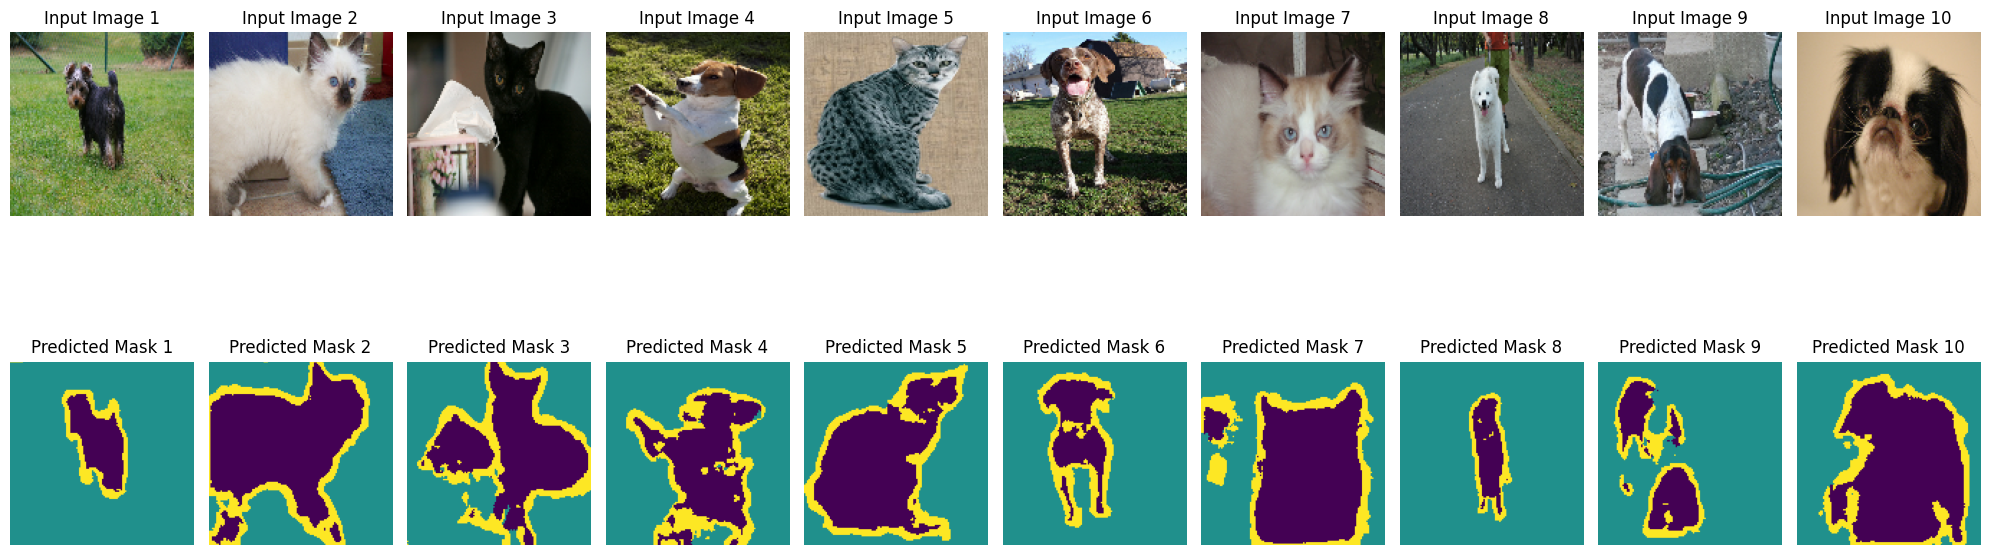

In [ ]:
print(" Displaying results...")
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
for i in range(10):
    # Plot original image
    axes[0, i].imshow(image_batch[i])
    axes[0, i].set_title(f"Input Image {i + 1}")
    axes[0, i].axis("off")

    # Plot predicted mask
    axes[1, i].imshow(predicted_masks[i], cmap="viridis")
    axes[1, i].set_title(f"Predicted Mask {i + 1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.savefig("unet_segmentation_results.png", dpi=150)
plt.show()

print("\nFigure saved as 'unet_segmentation_results.png'")

## **Conclusion**

This notebook demonstrates how to set up and run the Bonsai U-Net model. Here you can:

1. **Instantiated the U-Net model** with a specific configuration.
2. **Created synthetic data** for a simple segmentation task.
3. **Performed a forward pass** to get the model's output logits.
4. **Visualized the output**, confirming the model produces a mask of the correct dimensions.